In [1]:
from srcmap import *
from mask import *
from utils_plotting import *

In [6]:
inst = 1
make_srcmap_class = make_srcmap(inst, Re2 = 2)
srcmap = make_srcmap_class.run_srcmap(ptsrc=True)
modmap = make_srcmap_class.run_srcmap()
mzmask = MZ14_mask(inst, make_srcmap_class.xls, 
                   make_srcmap_class.yls, make_srcmap_class.ms_inband)

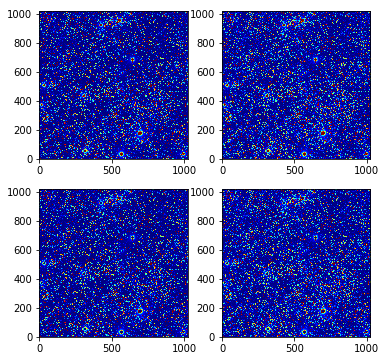

In [41]:
fig, ax = plt.subplots(2,2,figsize=(6,6))
ax0objs = imageclip(srcmap, ax=ax[0][0], cbar=False, return_objects=True)
vmin, vmax = ax0objs['vmin'], ax0objs['vmax']
imageclip(modmap, ax=ax[0][1], vmin=vmin, vmax=vmax, cbar=False)
imageclip(srcmap*mzmask, ax=ax[1][0], vmin=vmin, vmax=vmax, cbar=False)
imageclip(modmap*mzmask, ax=ax[1][1], vmin=vmin, vmax=vmax, cbar=False)

In [53]:
radmap = make_radius_map(np.zeros([101,101]),50,50)